In [2]:
from IPython.display import display, HTML
import math
from tqdm.auto import tqdm
import pandas as pd
import ujson
import numpy as np;
import pickle
import os
import xnetwork as xn
import bgzf
import struct
import os
import igraph as ig
import matplotlib.pyplot as plt 
from os.path import join as PJ
import gzip
import sys
import re
from datetime import datetime as dt
import sys
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to /u/filsilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Set the Path to MAG 
MAGPath = "/gpfs/sciencegenome/Journal2JournalData/mag/"
dataPath = PJ("..","..","Data","Processed")
figuresPath = PJ("..","..","Figures")
graycolor = "#808080"
paper2paperPath = PJ(dataPath,"WOSPaper2Paper.bgz")
HCAProjectDataPath = "HumanCellAtlas.json"
HGPTitles2MAGPath = "HGP_Publications_MAG.tsv"

In [4]:
# MAG PATH and parameters
MAGPath = "/gpfs/sciencegenome/Journal2JournalData/mag/"
# MAGPath = "/home/filsilva/Journal2Journal/Data/Raw/"
minPaperCount = 1;
rebuildAll = False

In [5]:
# dataPath = PJ("..","..","Data","ProcessedNew")
temporaryPath = PJ("..","..","Temp")
os.makedirs(dataPath, exist_ok=True)
os.makedirs(temporaryPath, exist_ok=True)

In [6]:
def dictFromList(aList):
    return {aList[i]:i for i in range(len(aList))}

In [8]:
STOPWORDS = stopwords.words('english')
STOPWORDS = set(STOPWORDS)
import re
def text_prepare(text, STOPWORDS=STOPWORDS):
    """
        text: a string
        
        return: a clean string
    """
    REPLACE_BY_SPACE_RE = re.compile('[\n\"\'/(){}\[\]\|@,;#\.]')
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # delete stopwords from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) 
    text = text.strip()
    return text

In [9]:
sortedPapersFilePath = PJ(dataPath,"MAGPapersByPaper.txt");
bgzPapersFilePath = PJ(dataPath,"MAGPapers.bgz");

papersDataTypes = [
    ("PaperId", int),
    ("Rank", int),
    ("Doi", str),
    ("DocType", str),
    ("PaperTitle", str),
    ("OriginalTitle", str),
    ("BookTitle", str),
    ("Year", int),
    ("Date", str),
    ("OnlineDate", str),
    ("Publisher", str),
    ("JournalId", int),
    ("ConferenceSeriesId", int),
    ("ConferenceInstanceId", int),
    ("Volume", str),
    ("Issue", str),
    ("FirstPage", str),
    ("LastPage", str),
    ("ReferenceCount", int),
    ("CitationCount", int),
    ("EstimatedCitation", int),
    ("OriginalVenue", str),
    ("FamilyId", int),
    ("FamilyRank",int),
    ("CreatedDate", str),
]

In [10]:
%load_ext Cython

In [11]:
%%cython
import bgzf
from tqdm.auto import tqdm
import os
from os.path import join as PJ
import bgzf
import struct

# Getting paperMetadata
def processTitleYearJournal(bgzPapersFilePath,papersDataTypes):
    estimatedCount = 233745561;
    index2magID = []
    index2Title = []
    index2DOI = []
    index2Year = []
    index2OnlineDate = []
    index2JournalID = []
    count = 0;
    with bgzf.open(bgzPapersFilePath,"rb") as infd:
        pbar = tqdm(total=estimatedCount);
        while True:
            pbar.update(1);
            lengthData = infd.read(8);
            if(len(lengthData)==8):
                length = struct.unpack("<q",lengthData)[0];
            else:
                break;
            data = infd.read(length);
            paperIndex = struct.unpack("<q",data[0:8])[0];
            currentPointer = 8;
    #         paperID = struct.unpack("<q",data[8:16])[0];
            dataDict = {};
            for (typeIndex,(typeName,typeType)) in enumerate(papersDataTypes):
                if(typeType==int):
                    entryValue, = struct.unpack("<q",data[currentPointer:currentPointer+8]);
                    currentPointer+=8;
                    dataDict[typeName] = entryValue;
                else:
                    entryLength, = struct.unpack("<q",data[currentPointer:currentPointer+8]);
                    currentPointer+=8;
                    entryData = data[currentPointer:currentPointer+entryLength].decode("utf8");
                    currentPointer+=entryLength;
                    dataDict[typeName] = entryData;
            index2Title.append(dataDict["PaperTitle"])
            index2Year.append(dataDict["Year"])
            index2magID.append(dataDict["PaperId"])
            index2DOI.append(dataDict["Doi"])
            index2OnlineDate.append(dataDict["OnlineDate"])
            index2JournalID.append(dataDict["JournalId"])
            count+=1;
#             if(count>100000):
#                 break;
    return index2Title,index2magID,index2Year,index2OnlineDate,index2JournalID,index2DOI;
            

In [12]:
index2Title,index2magID,index2Year,index2OnlineDate,index2JournalID,index2DOI=processTitleYearJournal(bgzPapersFilePath,papersDataTypes)
index2FirstYear = []
for i in tqdm(range(len(index2Year))):
    year = index2Year[i]
    if(index2OnlineDate[i]):
        onlineDate = int(index2OnlineDate[i][0:4])
        if(onlineDate<year):
            year=onlineDate
    index2FirstYear.append(year)
del index2OnlineDate


KeyboardInterrupt: 

In [ ]:
magID2Index = dictFromList(index2magID)

In [48]:
# Schema

# PAPER EXTENDED ATTRIBUTES
# Column #	Name	Type	Note
# 1	PaperId	long	FOREIGN KEY REFERENCES Papers.PaperId
# 2	AttributeType	int	1: PatentId
#                       2: PubMedId
#                       3: PmcId
#                       4: Alternative Title
# 3	AttributeValue	string	

#WRITE
paperExtendedAttributesFilePath = PJ(MAGPath,"PaperExtendedAttributes.txt.gz");
index2PubMedId = [None]*len(index2magID)
index2PmcId = [None]*len(index2magID)
missingPaperIDs = set()
estimatedCount = 233745561;
previousPaperID = 0
currentIndex = 0
magCount = len(index2magID)
with gzip.open(PJ(MAGPath,"PaperExtendedAttributes.txt.gz"),"rt") as fd:
    pbar = tqdm(total=estimatedCount);
    pbar2 = tqdm(total=estimatedCount);
    for line in fd:
        pbar.update(1);
        entries = line.strip().split("\t");
        paperID = int(entries[0]);
        if(paperID<previousPaperID):
            print("Problem!!! Out of order!")
            break
        previousPaperID = paperID;
        currentMAGID = index2magID[currentIndex]
        while(currentMAGID<paperID and currentIndex<magCount):
            currentIndex+=1;
            currentMAGID = index2magID[currentIndex]
            pbar2.update(1);
        if(currentMAGID==paperID):
            attributeType = int(entries[1]);
            attributeValue = str(entries[2]);
            if(attributeType==2):
                index2PubMedId[currentIndex] = attributeValue
            if(attributeType==3):
                index2PmcId[currentIndex] = attributeValue
        else:
            continue;
            
            
            
            
        

In [61]:
# Matching
with open(HCAProjectDataPath,"rt") as fd:
    HCAProjectData = ujson.load(fd);
for entry in HCAProjectData:
    if("links" in entry):
        entry.update({x.split(": ")[0]:x.split(": ")[1] for x in entry["links"] if len(x.split(": "))>1})

In [66]:
#PMC
#DOI
#TITLES
#PUBMED

#HCA Match2MAG
HCAProjectDOISets = {}
HCAProjectTitleSets = {}
HCAProjectPMCSets = {}
HCAProjectPUBMEDSets = {}
for entry in HCAProjectData:
    if("DOI" in entry):
        HCAProjectDOISets[entry["DOI"].lower()] = entry;
        
    if("PMC" in entry):
        HCAProjectPMCSets[entry["PMC"].lower()] = entry;
        
    if("PUBMED" in entry):
        HCAProjectPUBMEDSets[entry["PUBMED"].lower()] = entry;
        
    HCAProjectTitleSets[text_prepare(entry["title"].lower())] = entry;


In [80]:
selectedDOIMatches = {}
selectedTitleMatches = {}
selectedPMCMatches = {}
selectedPUBMEDMatches = {}
for i in tqdm(range(len(index2Year))):
    DOI = index2DOI[i].lower()
    if(DOI in HCAProjectDOISets):
        selectedDOIMatches[DOI] = i;
        continue;
    
    PMCID = index2PmcId[i]
    if(PMCID):
        PMCID = PMCID.lower() 
        if(PMCID in HCAProjectPMCSets):
            selectedPMCMatches[PMCID] = i;
            continue;
    
    PUBMEDID = index2PubMedId[i]
    if(PUBMEDID):
        PUBMEDID = PUBMEDID.lower() 
        if(PUBMEDID in HCAProjectPUBMEDSets):
            selectedPUBMEDMatches[PUBMEDID] = i;
            continue;
    
    reducedTitle = text_prepare(index2Title[i].lower())
    if(reducedTitle in HCAProjectTitleSets):
        selectedTitleMatches[reducedTitle] = i;
        continue;

In [106]:
HCAProjectMAGIndices = set(selectedDOIMatches.values()).union(set(selectedTitleMatches.values()))


In [253]:
#Human Cell Atlas
HCAMissingData = []
for entry in HCAProjectData:
    matchesCount = 0;
    if("DOI" in entry and entry["DOI"].lower() in selectedDOIMatches):
        matchesCount+=1
    if("title" in entry and text_prepare(entry["title"].lower()) in selectedTitleMatches):
        matchesCount+=1
    if(matchesCount>0):
#         print(checkDouble);
        continue
    HCAMissingData.append(entry)
# print(missingData)
with open("HCA_MAGIndices.json","wt") as fd:
    ujson.dump(HCAProjectMAGIndices,fd)
    
with open("HCA_MissingEntries.json","wt") as fd:
    ujson.dump(HCAMissingData,fd)

In [401]:
#Human Genome Project
dfHGP = pd.read_csv(HGPTitles2MAGPath,sep="\t")
HGPProjectMAGIndices = set()
HGPMissingData = []
for referece,url in dfHGP[["Reference","MAG URL"]].to_numpy():
    if(url==url):
        magID = int(re.search(r'https\:\/\/academic\.microsoft\.com\/paper\/(.*?)\/reference', url).group(1))
        if(magID in magID2Index):
            index = magID2Index[magID]
            HGPProjectMAGIndices.add(index)
            continue;
        
    HGPMissingData.append(referece);

with open("HGP_MAGIndices.json","wt") as fd:
    ujson.dump(HGPProjectMAGIndices,fd)
    
with open("HGP_MissingEntries.json","wt") as fd:
    ujson.dump(HGPMissingData,fd)

In [166]:
HBMapDataPaths = [
    "Pubhl_Export_21Jan2021_084406.csv",
    "Pubhl_Export_21Jan2021_084445.csv",
    "Publ_18Jan2021_014100_86642982.csv"
]

In [216]:
HBMapTitleKey = "Title (Link to full-text in PubMed Central)"
HBMapDfs = [pd.read_csv(filename,dtype={"PMC ID":str,"PMID":str}) for filename in HBMapDataPaths]
HBMapDf = pd.concat(HBMapDfs,sort=False)

In [227]:
HBMapTitles = HBMapDf[HBMapTitleKey].to_list()
HBMapReducedTitles = set(text_prepare(title.lower()) for title in HBMapTitles if isinstance(title,str))
HBMapPMCIDs = set(pmcid.lower() for pmcid in HBMapDf["PMC ID"].to_list() if isinstance(pmcid,str))
HBMapPUBMEDIDs = set(pubmedID.lower() for pubmedID in HBMapDf["PMID"].to_list() if isinstance(pubmedID,str))

In [229]:
HBMapSelectedDOIMatches = {}
HBMapSelectedTitleMatches = {}
HBMapSelectedPMCMatches = {}
HBMapSelectedPUBMEDMatches = {}

pbarnew = tqdm(desc='Added');
for i in tqdm(range(len(index2Year))):    
    PMCID = index2PmcId[i]
    if(PMCID):
        PMCID = PMCID.lower() 
        if(PMCID in HBMapPMCIDs):
            HBMapSelectedPMCMatches[PMCID] = i;
            pbarnew.update(1);
            continue;
    
    PUBMEDID = index2PubMedId[i]
    if(PUBMEDID):
        PUBMEDID = PUBMEDID.lower() 
        if(PUBMEDID in HBMapPUBMEDIDs):
            HBMapSelectedPUBMEDMatches[PUBMEDID] = i;
            pbarnew.update(1);
            continue;
    
    reducedTitle = text_prepare(index2Title[i].lower())
    if(reducedTitle in HBMapReducedTitles):
        HBMapSelectedTitleMatches[reducedTitle] = i;
        pbar2.update(1);
        continue;

In [297]:
HBMapProjectMAGIndices = set(HBMapSelectedPMCMatches.values()).union(set(HBMapSelectedPUBMEDMatches.values()).union(set(HBMapSelectedTitleMatches.values())))

HBMapMissingData = []
for title,PMCID,PMID in HBMapDf[[HBMapTitleKey,"PMC ID","PMID"]].to_numpy():
    matchesCount = 0;
    if(PMCID in HBMapSelectedPMCMatches):
        matchesCount+=1
    if(PMID in HBMapSelectedPUBMEDMatches):
        matchesCount+=1
    if(title==title and text_prepare(title.lower()) in HBMapSelectedTitleMatches):
        matchesCount+=1
    if(matchesCount>0):
#         print(checkDouble);
        continue
    if(title==title):
        HBMapMissingData.append(title)
        
HBMapMissingData = set(HBMapMissingData)

#Included by manually searching missing in MAG
HBMapManualMAGIDIncludes = [
    3092960214,
    3099559583,
    3099294714,
    3089472526,
    3100967665,
    3038602829,
    3092108146,
    3081828282,
    3099559583,
]
#Only adding matches in currentMAGData
for magID in HBMapManualMAGIDIncludes:
    if(magID in magID2Index):
        HBMapProjectMAGIndices.add(magID2Index[magID])

with open("HBMap_MAGIndices.json","wt") as fd:
    ujson.dump(HBMapProjectMAGIndices,fd)
    
with open("HBMap_MissingEntries.json","wt") as fd:
    ujson.dump(HBMapMissingData,fd)

In [402]:
#Statistics:
print("Summary")
print("HCA")
print("\tMatches: %d\n\tMissing:%d"%(len(HCAProjectMAGIndices),len(HCAMissingData)))
print("HuBMap")
print("\tMatches: %d\n\tMissing:%d"%(len(HBMapProjectMAGIndices),len(HBMapMissingData)))
print("HGP")
print("\tMatches: %d\n\tMissing:%d"%(len(HGPProjectMAGIndices),len(HGPMissingData)))

Summary
HCA
	Matches: 50
	Missing:12
HuBMap
	Matches: 42
	Missing:8
HGP
	Matches: 86
	Missing:20


In [ ]:

with open("HCA_MAGIndices.json","rt") as fd:
    HCAProjectMAGIndices = set(ujson.load(fd))
    
with open("HBMap_MAGIndices.json","rt") as fd:
    HBMapProjectMAGIndices = set(ujson.load(fd))
    
with open("HGP_MAGIndices.json","rt") as fd:
    HGPProjectMAGIndices = set(ujson.load(fd))

In [54]:
#references FromTo
estimatedCount = 79684807;
bgzReferencesFromToPath = PJ(dataPath,"MAGPaperReferencesFromTo.bgz");
entriesCount = 0;
# setOfJournalsReferenced = set()
# setOfJournalsWithPublications = set()
HCACitationsPerYear = {};
HBMapCitationsPerYear = {};
HCAHuBMapCitationsPerYear = {};
HGPCitationsPerYear = {};

projectCitations = {
    "HCA":(HCAProjectMAGIndices,HCACitationsPerYear),
    "HuBMap":(HBMapProjectMAGIndices,HBMapCitationsPerYear),
    "HCA+HuBMap":(HBMapProjectMAGIndices.union(HCAProjectMAGIndices),HCAHuBMapCitationsPerYear),
    "HGP":(HGPProjectMAGIndices,HGPCitationsPerYear)
}

MAGID2CitationYear = {};
with bgzf.open(bgzReferencesFromToPath,"rb") as infd:
    pbar = tqdm(total=estimatedCount);
    count = 0;
    while True:
        pbar.update(1);
        lengthData = infd.read(8);
        if(len(lengthData)==8):
            length = struct.unpack("<q",lengthData)[0];
        else:
            break;
        data = infd.read(length);
        edgesCount = length/8-1;
        fmt = "<%dq" % (edgesCount+1)
        edgeData  = list(struct.unpack(fmt,data))
        fromIndex = edgeData[0];
        fromID = index2magID[fromIndex]
        count+=1;
        if(len(edgeData)>1):
            year = index2FirstYear[fromIndex];
            for projectName,(indices,citationsPerYear) in projectCitations.items():
                toIndices = set(edgeData[1:]).intersection(indices)
                if(toIndices):
                    if(year not in citationsPerYear):
                        citationsPerYear[year] = set();
                    citationsPerYear[year].add(fromIndex);
                    for toID in [index2magID[index] for index in toIndices]:
                        if(toID not in MAGID2CitationYear):
                            MAGID2CitationYear[toID] = [];
                        MAGID2CitationYear[toID].append((fromID,year));
            


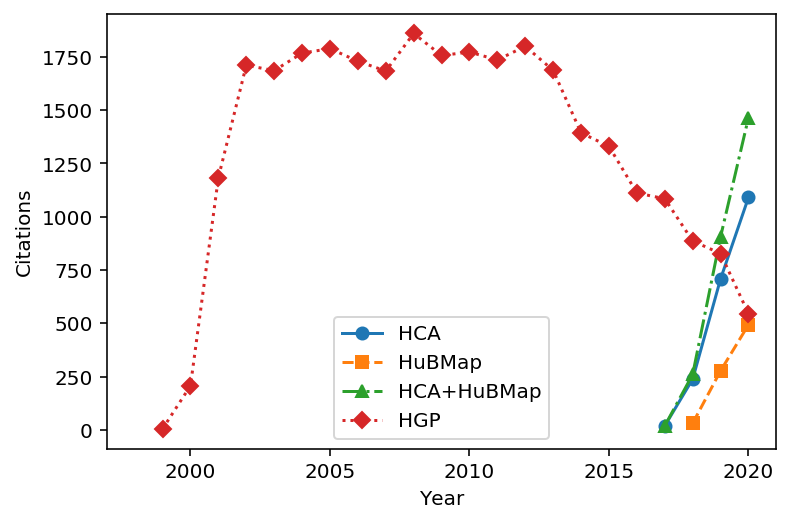

In [71]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
citationsByProject = {}
cumulativeCitationsByProject = {}
for plotIndex,(projectName,(indices,citationsPerYear)) in enumerate(projectCitations.items()):
    
    yearCitations = [(year,len(citations)) for year,citations in citationsPerYear.items() if year>=minYear and year<=maxYear]
    yearCitations = sorted(yearCitations,key=lambda y:y[0])
    years,citations = list(zip(*yearCitations))
    citationsByProject[projectName] = [list(years),list(citations)]
    cumulativeCitationsByProject[projectName] = [list(years),np.cumsum(citations).tolist()]
    
    ax.plot(years,citations,markerStyles[plotIndex%len(markerStyles)],label=projectName);
	
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Citations")
ax.set_xlim(1997,2021)
plt.savefig("../../Figures/BioMedCitations.pdf")
plt.show()

In [74]:
with open("../../Data/BioMed_CitationsData.json","wt") as fd:
    ujson.dump(citationsByProject,fd)
with open("../../Data/BioMed_CumulativeCitationsData.json","wt") as fd:
    ujson.dump(cumulativeCitationsByProject,fd)

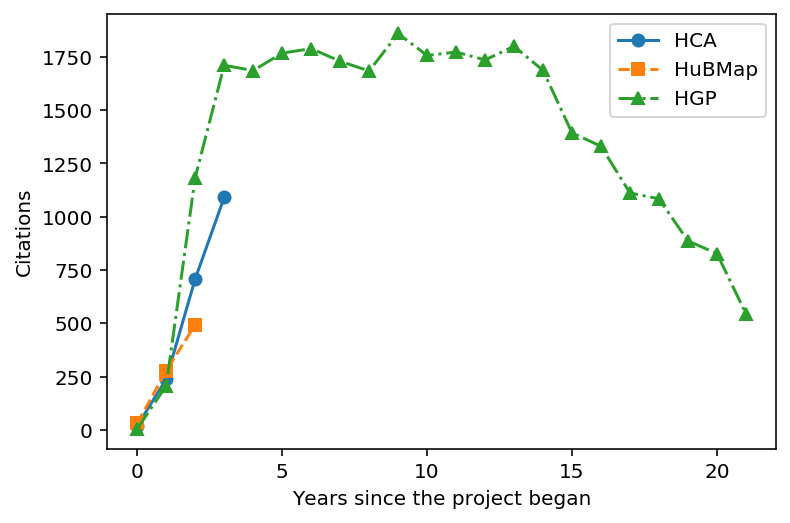

In [51]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
citationsByProject = {}
cumulativeCitationsByProject = {}
for plotIndex,(projectName,(indices,citationsPerYear)) in enumerate(projectCitations.items()):
    
    yearCitations = [(year,len(citations)) for year,citations in citationsPerYear.items() if year>=minYear and year<=maxYear]
    yearCitations = sorted(yearCitations,key=lambda y:y[0])
    years,citations = list(zip(*yearCitations))
    citationsByProject[projectName] = (years,citations)
    cumulativeCitationsByProject[projectName] = (years,np.cumsum(citations))
    
    ax.plot(range(len(years)),citations,markerStyles[plotIndex%len(markerStyles)],label=projectName);
	
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Citations")
# ax.set_xlim(1997,2021)
plt.savefig("../../Figures/BioMedCitationsSinceStart.pdf")
plt.show()

In [34]:
#Number of citations
for name,(year,cumualtiveCitations) in cumulativeCitationsByProject.items():
  print("%s: %d"%(name,cumualtiveCitations[-1]))

HCA: 2055
HuBMap: 801
HGP: 29540


In [ ]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,citationsPerYear)) in enumerate(projectCitations.items()):
    
    yearCitations = [(year,len(citations)) for year,citations in citationsPerYear.items() if year>=minYear and year<=maxYear]
    yearCitations = sorted(yearCitations,key=lambda y:y[0])
    years,citations = list(zip(*yearCitations))

    ax.plot(years,citations,markerStyles[plotIndex%len(markerStyles)],label=projectName);
	
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Citations")
ax.set_xlim(1997,2021)
plt.savefig("../../Figures/BioMedCitations.pdf")
plt.show()

In [ ]:
HCAAffiliationsPerYear = {};
HuBMapAffiliationsPerYear = {};
HGPAffiliationsPerYear = {};

HCAAuthorsPerYear = {};
HuBMapAuthorsPerYear = {};
HGPAuthorsPerYear = {};

projectAuthorAffiliations = {
    "HCA":(HCAProjectMAGIndices,HCAAffiliationsPerYear,HCAAuthorsPerYear),
    "HuBMap":(HBMapProjectMAGIndices,HuBMapAffiliationsPerYear,HuBMapAuthorsPerYear),
    "HuBMap+HCA":(HBMapProjectMAGIndices,HuBMapAffiliationsPerYear,HuBMapAuthorsPerYear),
    "HGP":(HGPProjectMAGIndices,HGPAffiliationsPerYear,HGPAuthorsPerYear)
}

allMAGIDs = {index2magID[entry] for entry in HCAProjectMAGIndices|HBMapProjectMAGIndices|HGPProjectMAGIndices}

MAGID2AuthorsIDs = {}
MAGID2AffiliationIDs = {}

estimatedCount = 655732564;# Used just to display status
with open(PJ(MAGPath,"PaperAuthorAffiliations.txt"),"rt") as fd:
    pbar = tqdm(total=estimatedCount);
    for line in fd:
        pbar.update(1);
        entries = line.split("\t");
        paperID = int(entries[0]);
        if(paperID in allMAGIDs):
            paperAuthorID = int(entries[1]);
            if(entries[2].isdigit()):
                paperAffiliationID = int(entries[2]);
            else:
                paperAffiliationID=0;
            authorOrder = int(entries[3]);
            paperIndex = magID2Index[paperID]
            paperYear = index2FirstYear[paperIndex]
            if(paperID not in MAGID2AuthorsIDs):
                MAGID2AuthorsIDs[paperID] = [];

            if(paperID not in MAGID2AffiliationIDs):
                MAGID2AffiliationIDs[paperID] = [];
            
            MAGID2AuthorsIDs[paperID].append(paperAuthorID);
            MAGID2AffiliationIDs[paperID].append(paperAffiliationID);
            
            for projectName,(indices,affiliationsPerYear,authorsPerYear) in projectAuthorAffiliations.items():
                if(paperIndex in indices):
                    if(paperYear not in authorsPerYear):
                        authorsPerYear[paperYear] = set();
                    authorsPerYear[paperYear].add(paperAuthorID);
                    if(paperAffiliationID):
                        if(paperYear not in affiliationsPerYear):
                            affiliationsPerYear[paperYear] = set();
                        affiliationsPerYear[paperYear].add(paperAffiliationID);

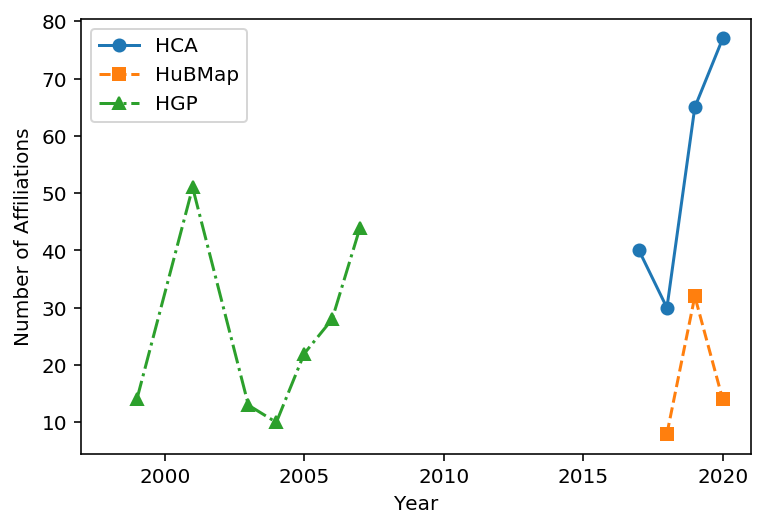

In [45]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,affiliationsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    
    yearAffiliations = [(year,len(affiliations)) for year,affiliations in affiliationsPerYear.items() if year>=minYear and year<=maxYear]
    yearAffiliations = sorted(yearAffiliations,key=lambda y:y[0])
    years,affiliations = list(zip(*yearAffiliations))

    ax.plot(years,affiliations,markerStyles[plotIndex%len(markerStyles)],label=projectName);

ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Affiliations")
plt.savefig("../../Figures/BioMedAffiliations.pdf")
plt.show()

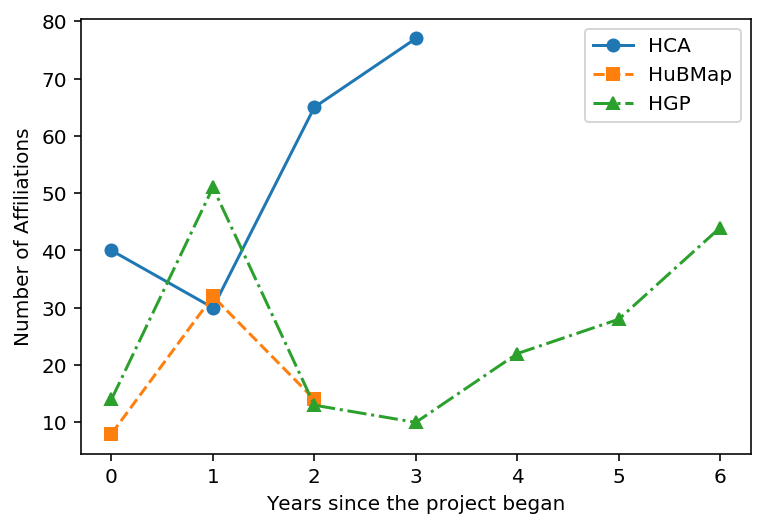

In [46]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,affiliationsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    
    yearAffiliations = [(year,len(affiliations)) for year,affiliations in affiliationsPerYear.items() if year>=minYear and year<=maxYear]
    yearAffiliations = sorted(yearAffiliations,key=lambda y:y[0])
    years,affiliations = list(zip(*yearAffiliations))

    ax.plot(range(len(years)),affiliations,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Number of Affiliations")
plt.savefig("../../Figures/BioMedAffiliationsSinceStart.pdf")
plt.show()

HCA: 146
HuBMap: 40
HGP: 117


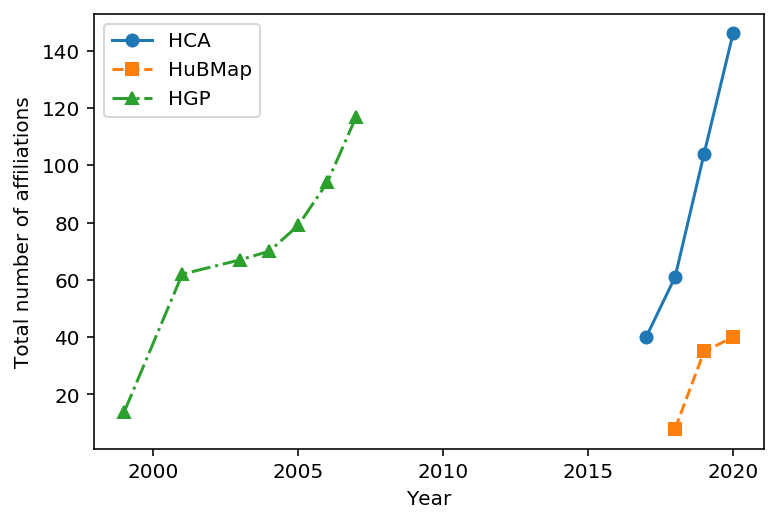

In [48]:
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,affiliationsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    totalAffiliations = set()
    yearAffiliations = sorted(affiliationsPerYear.items(),key=lambda y:y[0])
    affiliationsCounts = []
    years = []
    for year,affiliations in yearAffiliations:
        if year>=minYear and year<=maxYear:
            totalAffiliations.update(affiliations);
            affiliationsCounts.append(len(totalAffiliations))
            years.append(year);
    
    
    ax.plot(years,affiliationsCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);
    print("%s: %d"%(projectName,affiliationsCounts[-1]))
# ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Total number of affiliations")
plt.savefig("../../Figures/BioMedAffiliationsTotal.pdf")
plt.show()

HCA: 146
HuBMap: 40
HGP: 117


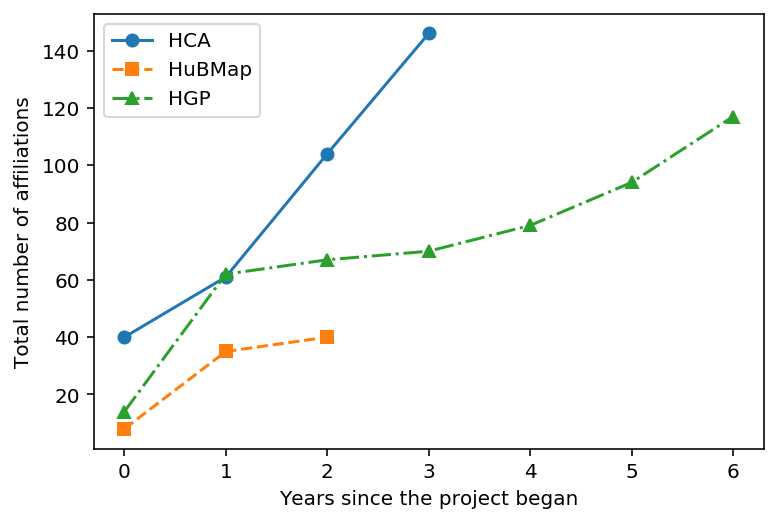

In [47]:
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,affiliationsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    totalAffiliations = set()
    yearAffiliations = sorted(affiliationsPerYear.items(),key=lambda y:y[0])
    affiliationsCounts = []
    years = []
    for year,affiliations in yearAffiliations:
        if year>=minYear and year<=maxYear:
            totalAffiliations.update(affiliations);
            affiliationsCounts.append(len(totalAffiliations))
            years.append(year);
    
    
    ax.plot(range(len(years)),affiliationsCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);
    print("%s: %d"%(projectName,affiliationsCounts[-1]))
# ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Total number of affiliations")
plt.savefig("../../Figures/BioMedAffiliationsTotalSinceStart.pdf")
plt.show()

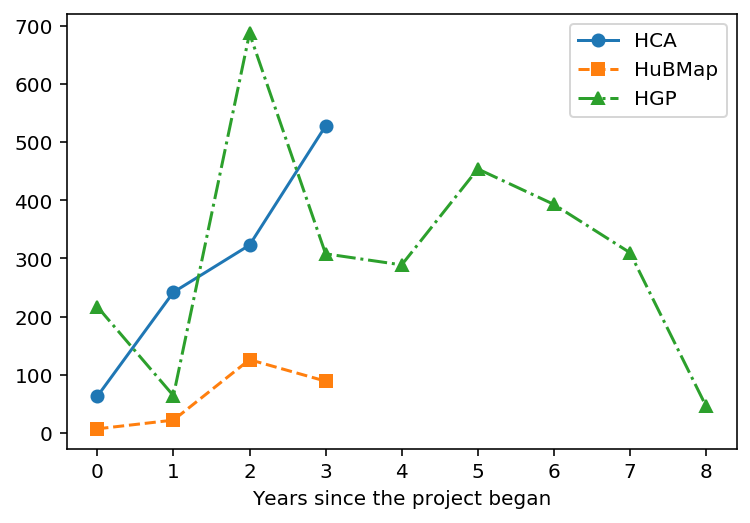

In [40]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,authorsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    
    yearAuthors = [(year,len(authors)) for year,authors in authorsPerYear.items() if year>=minYear and year<=maxYear]
    yearAuthors = sorted(yearAuthors,key=lambda y:y[0])
    years,authors = list(zip(*yearAuthors))

    ax.plot(range(len(years)),authors,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_xlabel("Years since the project began")
plt.savefig("../../Figures/BioMedAuthorsSinceStart.pdf")
plt.show()

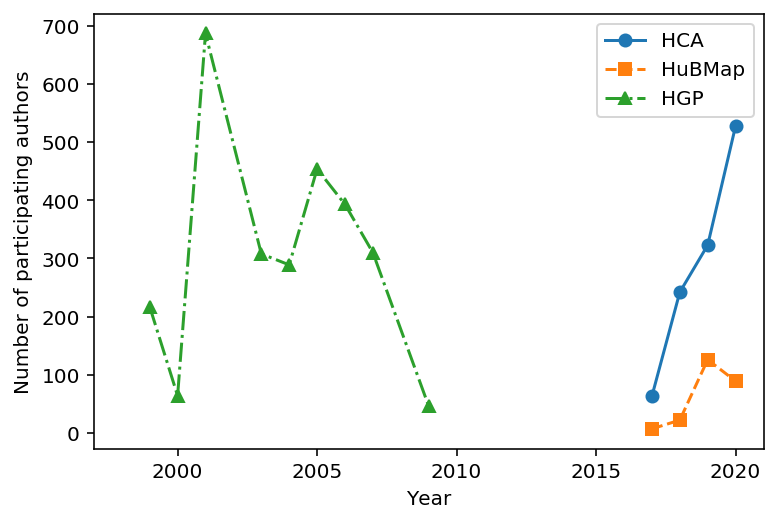

In [39]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,authorsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    
    yearAuthors = [(year,len(authors)) for year,authors in authorsPerYear.items() if year>=minYear and year<=maxYear]
    yearAuthors = sorted(yearAuthors,key=lambda y:y[0])
    years,authors = list(zip(*yearAuthors))

    ax.plot(years,authors,markerStyles[plotIndex%len(markerStyles)],label=projectName);

ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Number of participating authors")
plt.savefig("../../Figures/BioMedAuthors.pdf")
plt.show()

HCA: 1003
HuBMap: 200
HGP: 2056


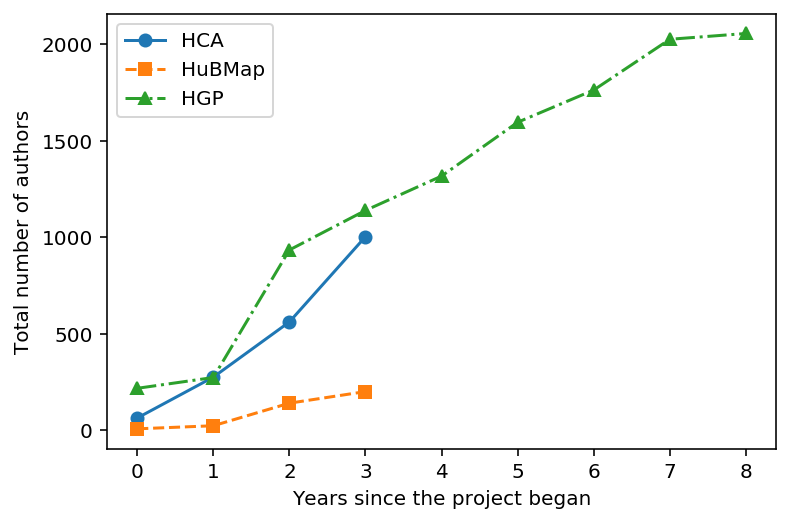

In [43]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,authorsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    totalAuthors = set()
    yearAuthors = sorted(authorsPerYear.items(),key=lambda y:y[0])
    authorsCounts = []
    years = []
    for year,authors in yearAuthors:
        if year>=minYear and year<=maxYear:
            totalAuthors.update(authors);
            authorsCounts.append(len(totalAuthors))
            years.append(year);
    
    
    ax.plot(range(len(years)),authorsCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);
    print("%s: %d"%(projectName,authorsCounts[-1]))
# ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Years since the project began")
ax.set_ylabel("Total number of authors")
plt.savefig("../../Figures/BioMedAuthorsTotalSinceStart.pdf")
plt.show()

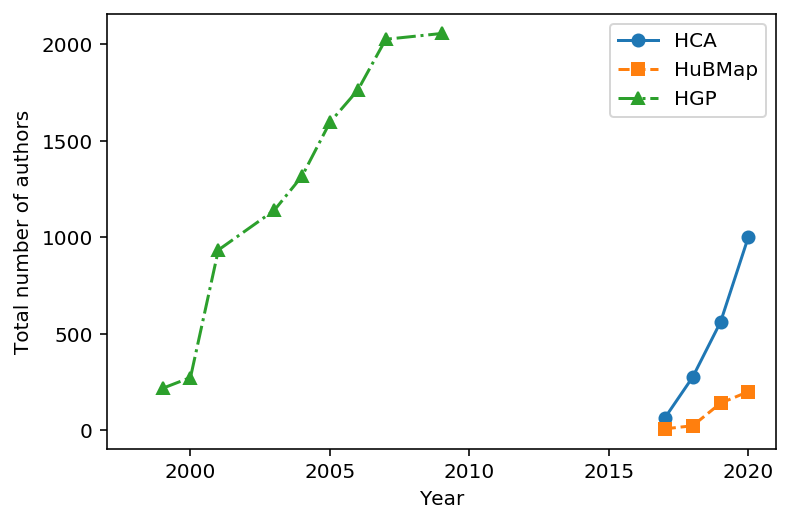

In [38]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(indices,authorsPerYear,authorsPerYear)) in enumerate(projectAuthorAffiliations.items()):
    totalAuthors = set()
    yearAuthors = sorted(authorsPerYear.items(),key=lambda y:y[0])
    authorsCounts = []
    years = []
    for year,authors in yearAuthors:
        if year>=minYear and year<=maxYear:
            totalAuthors.update(authors);
            authorsCounts.append(len(totalAuthors))
            years.append(year);
    
    
    ax.plot(years,authorsCounts,markerStyles[plotIndex%len(markerStyles)],label=projectName);

ax.set_xlim(1997,2021)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Total number of authors")
plt.savefig("../../Figures/BioMedAuthorsTotal.pdf")
plt.show()

In [ ]:
[index2magID[index] for index in HGPProjectMAGIndices if index2FirstYear[index]>2008]

,NIH Spending Categorization,Project Terms,Project Title,Public Health Relevance,Administering IC,Application ID,Award Notice Date,FOA,Project Number,Type,Activity,IC,Serial Number,Support Year,Suffix,Program Official Information,Project Start Date,Project End Date,Study Section,Subproject Number,Contact PI Person ID,Contact PI / Project Leader,Other PI or Project Leader(s),Congressional District,Department,DUNS Number,FIPS,Latitude,Longitude,Organization ID (IPF),Organization Name,Organization City,Organization State,Organization Type,Organization Zip,Organization Country,ARRA Indicator,Budget Start Date,Budget End Date,CFDA Code,Funding Mechanism,Fiscal Year,Total Cost,Total Cost (Sub Projects),Funding IC(s),Direct Cost IC,InDirect Cost IC,NIH COVID-19 Response,Project Abstract,Total Cost IC
0,No NIH Category available,Atlases;Biomedical Research;Collaborations;Com...,HuBMAP HIVE Tools Component Supplement,PROJECT NARRATIVE\nTo gain a better understand...,OD,10148334,6/22/2020,PA-18-591,3OT2OD026677-01S3,3,OT2,OD,26677,1,S,"BEST, TYLER KORY",9/21/2018,9/20/2022,NaN,NaN,10917418,"GEHLENBORG, NILS",Not Applicable,7,MISCELLANEOUS,47006379,US,42.335814,-71.105033,3212902,HARVARD MEDICAL SCHOOL,BOSTON,MA,SCHOOLS OF MEDICINE,21156027,UNITED STATES,N,6/21/2020,6/20/2021,310,Other,2020,998455,NaN,OD,589102,409353,NaN,PROJECT SUMMARY\nWe propose to contribute a su...,998455
1,No NIH Category available,Anatomy;Artificial Intelligence;Atlases;Biolog...,"The Human Body Atlas: High-Resolution, Functio...",Project Narrative\nThis project will create a ...,OD,10148333,6/22/2020,PA-18-591,3OT2OD026671-01S3,3,OT2,OD,26671,1,S,"BEST, TYLER KORY",9/21/2018,9/20/2022,NaN,NaN,6869311,"BORNER, KATY",Not Applicable,9,NONE,6046700,US,39.164557,-86.528225,577805,INDIANA UNIVERSITY BLOOMINGTON,BLOOMINGTON,IN,SCHOOLS OF ARTS AND SCIENCES,474013654,UNITED STATES,N,6/21/2020,6/20/2021,310,Other,2020,1000000,NaN,OD,631136,368864,NaN,Project Summary/Abstract\nThe ultimate goal of...,1000000
2,No NIH Category available,Cloud Computing;Grant;Human BioMolecular Atlas...,Flexible Hybrid Cloud Infrastructure for Seaml...,Project Narrative not required for PA‐18‐591 R...,OD,10150161,6/22/2020,PA-18-591,3OT2OD026675-01S4,3,OT2,OD,26675,1,S,"BEST, TYLER KORY",9/21/2018,9/20/2022,NaN,NaN,11762761,"NYSTROM, NICHOLAS A.","SILVERSTEIN, JONATHAN C.",18,NONE,52184116,US,40.443528,-79.955322,247601,CARNEGIE-MELLON UNIVERSITY,PITTSBURGH,PA,COMPUTER CENTER,152133815,UNITED STATES,N,6/21/2020,6/20/2021,310,Other,2020,2250000,NaN,OD,1831380,418620,NaN,Project Summary not required for PA‐18‐591 Req...,2250000
3,No NIH Category available,Algorithms;Anatomy;Atlases;Biological;Cells;Co...,"Comprehensive reference map construction, geol...",Project Narrative\nThe human body consists of ...,OD,10148855,6/22/2020,PA-18-591,3OT2OD026673-01S2,3,OT2,OD,26673,1,S,"BEST, TYLER KORY",9/21/2018,9/20/2022,NaN,NaN,11318116,"SATIJA, RAHUL","MARIONI, JOHN CARLO",10,Unavailable,78473711,US,NaN,NaN,10032222,NEW YORK GENOME CENTER,NEW YORK,NY,Research Institutes,100131941,UNITED STATES,N,6/21/2020,6/20/2021,310,Other,2020,697234,NaN,OD,466875,230359,NaN,Abstract\nThe healthy human body is composed o...,697234
4,No NIH Category available,Anatomy;Computing Methodologies;Data;Data Anal...,"Comprehensive, Flexible and FAIR Tools for the...",The Human BioMolecular Atlas Program (HuBMAP) ...,OD,10148079,6/22/2020,PA-18-591,3OT2OD026682-01S3,3,OT2,OD,26682,1,S,"BEST, TYLER KORY",9/21/2018,9/20/2022,NaN,NaN,8661172,"BAR-JOSEPH, ZIV","PATEN, BENEDICT ; TEICHMANN, SARAH",18,BIOSTATISTICS & OTHER MATH SCI,52184116,US,40.443528,-79.955322,247601,CARNEGIE-MELLON UNIVERSITY,PITTSBURGH,PA,SCHOOLS OF ARTS AND SCIENCES,152133815,UNITED STATES,N,6/21/2020,6/20/2021,310,Other,2020,1000000,NaN,OD,735992,264008,NaN,The Human BioMolecular Atlas Program (HuBMAP) ...,1000000
5,No NIH Category available,Anatomy;Atlases;Data;Data Analyses;Deposition;...,"Comprehensive, Flexible and FAIR Tools for the...",The Human BioMo

In [36]:

indicesByProject = {
"HCA" : HCAProjectMAGIndices,
"HuBMap" : HBMapProjectMAGIndices,
"HGP" : HGPProjectMAGIndices
}
magIDsByProject = {}
allMAGIDs = set()
for projectName,indices in indicesByProject.items():
    magIDsByProject[projectName] = {index2magID[index] for index in indices}
    allMAGIDs.update(magIDsByProject[projectName])

exportFilesByProject = {}
for projectName,indices in indicesByProject.items():
    exportFilesByProject[projectName] = open("../../Data/Papers_%s.tsv"%projectName,"w")
    headers = [entryName for entryName,_ in papersDataTypes]
    headers.append("Author IDs")
    headers.append("Affiliation IDs")
    headers.append("Citation IDs")
    headers.append("Citation Years")
    exportFilesByProject[projectName].write("\t".join(headers));
    exportFilesByProject[projectName].write("\n");
    

with open(PJ(MAGPath,"Papers.txt"),"rt") as fd:
    pbar = tqdm(total=estimatedCount);
    pbar2 = tqdm(desc="matches");
    for line in fd:
        pbar.update(1);
        entries = line.strip().split("\t");
        paperID = int(entries[0]);
        if(paperID in allMAGIDs):
            pbar2.update(1)
            for projectName,magIDs in magIDsByProject.items():
                if(paperID in magIDs):
                    exportFilesByProject[projectName].write(line.strip());
                    exportFilesByProject[projectName].write("\t%s"%";".join([str(entry) for entry in MAGID2AuthorsIDs[paperID] if entry!=0]))
                    exportFilesByProject[projectName].write("\t%s"%";".join([str(entry) for entry in MAGID2AffiliationIDs[paperID] if entry!=0]))
                    if(paperID in MAGID2CitationYear):
                        exportFilesByProject[projectName].write("\t%s"%";".join([str(entry) for entry,year in MAGID2CitationYear[paperID] if entry!=0]))
                        exportFilesByProject[projectName].write("\t%s"%";".join([str(year) for entry,year in MAGID2CitationYear[paperID] if year!=0]))
                    else:
                        exportFilesByProject[projectName].write("\t");
                        exportFilesByProject[projectName].write("\t");
                    exportFilesByProject[projectName].write("\n")
for projectName,indices in indicesByProject.items():
    exportFilesByProject[projectName].close()

In [135]:
pd.read_csv("../../Data/Papers_%s_v2.tsv"%"HuBMap+HCA",sep="\t").to_csv("../../Data/Papers_%s_v2.csv"%"HuBMap+HCA")

In [34]:
MAGID2AffiliationIDs[2138980320]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [54]:
MAGID2AuthorsIDs[paperID].append(paperAuthorID);
MAGID2AffiliationIDs[paperID].append(paperAffiliationID);

[('PaperId', int),
 ('Rank', int),
 ('Doi', str),
 ('DocType', str),
 ('PaperTitle', str),
 ('OriginalTitle', str),
 ('BookTitle', str),
 ('Year', int),
 ('Date', str),
 ('OnlineDate', str),
 ('Publisher', str),
 ('JournalId', int),
 ('ConferenceSeriesId', int),
 ('ConferenceInstanceId', int),
 ('Volume', str),
 ('Issue', str),
 ('FirstPage', str),
 ('LastPage', str),
 ('ReferenceCount', int),
 ('CitationCount', int),
 ('EstimatedCitation', int),
 ('OriginalVenue', str),
 ('FamilyId', int),
 ('FamilyRank', int),
 ('CreatedDate', str)]

In [ ]:
projectAuthorAffiliations

In [45]:

dfHCA = pd.read_csv("../../Data/Papers_%s.tsv"%"HCA",sep="\t")
dfHuBMap = pd.read_csv("../../Data/Papers_%s.tsv"%"HuBMap",sep="\t")


dfBioMed = {
    "HuBMap+HCA": pd.concat([dfHCA,dfHuBMap]).reset_index(),
    "HGP": pd.read_csv("../../Data/Papers_%s.tsv"%"HGP",sep="\t")
}

for projectName,df in dfBioMed.items():
    dfBioMed[projectName] = df.replace(np.nan, '', regex=True)
    

In [46]:
# dfBioMed[projectName]
"Affiliation IDs"
"Author IDs"
dfBioMed["HGP"]["Year"].min()

1999

In [54]:
totalAffiliationsByProject = {}
for projectName,dfProject in dfBioMed.items():
    affiliations = dfProject.groupby(['Year'])["Affiliation IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    affiliationCounts = []
    for year in range(minYear,maxYear+1):
        yearAffiliations = list(affiliations[affiliations["Year"]<=year]["Affiliation IDs"])
        yearAffiliationsMerge = ";".join(yearAffiliations)
        yearAffiliationsSet = set()
        for affiliationID in yearAffiliationsMerge.split(";"):
            affiliationID.strip().lower()
            if(affiliationID):
                yearAffiliationsSet.add(affiliationID);
        years.append(year)
        affiliationCounts.append(len(yearAffiliationsSet))
        print("%d\t%d"%(int(year),len(yearAffiliationsSet)))
    totalAffiliationsByProject[projectName] = [years,affiliationCounts]

HuBMap+HCA
2017	40
2018	66
2019	123
2020	168
HGP
1999	14
2000	14
2001	62
2002	62
2003	67
2004	70
2005	79
2006	94
2007	117
2008	117
2009	117


In [66]:
# dfProject[dfProject["Year"]==2009]

In [62]:
affiliationsByProject = {}
for projectName,dfProject in dfBioMed.items():
    affiliations = dfProject.groupby(['Year'])["Affiliation IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    affiliationCounts = []
    for year in range(minYear,maxYear+1):
        yearAffiliations = list(affiliations[affiliations["Year"]==year]["Affiliation IDs"])
        yearAffiliationsMerge = ";".join(yearAffiliations)
        yearAffiliationsSet = set()
        for affiliationID in yearAffiliationsMerge.split(";"):
            affiliationID.strip().lower()
            if(affiliationID):
                yearAffiliationsSet.add(affiliationID);
        years.append(year)
        affiliationCounts.append(len(yearAffiliationsSet))
        print("%d\t%d"%(int(year),len(yearAffiliationsSet)))
    affiliationsByProject[projectName] = [years,affiliationCounts]

HuBMap+HCA
2017	40
2018	36
2019	87
2020	90
HGP
1999	14
2000	0
2001	51
2002	0
2003	13
2004	10
2005	22
2006	28
2007	44
2008	0
2009	0


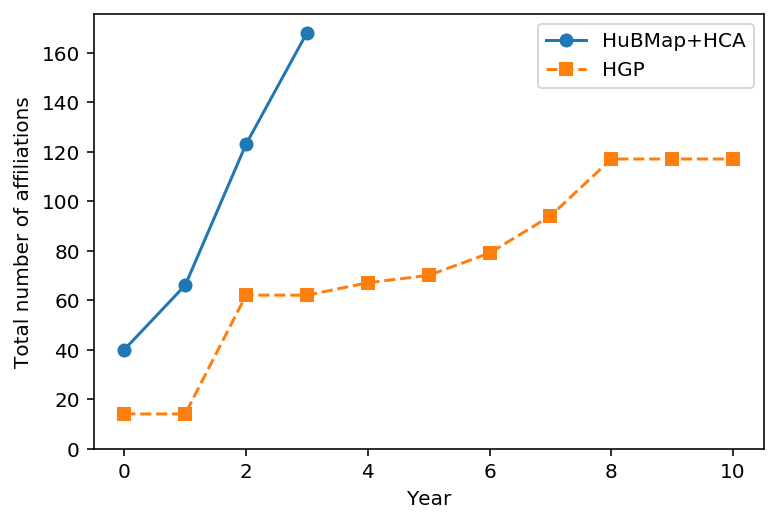

In [59]:
minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,affiliationCount)) in enumerate(totalAffiliationsByProject.items()):
    ax.plot(range(len(years)),affiliationCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Total number of affiliations")
plt.savefig("../../Figures/BioMedAffiliationsTotal_v2.pdf")
plt.show()

In [60]:
totalAuthorsByProject = {}
for projectName,dfProject in dfBioMed.items():
    authors = dfProject.groupby(['Year'])["Author IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    authorCounts = []
    for year in range(minYear,maxYear+1):
        yearAuthors = list(authors[authors["Year"]<=year]["Author IDs"])
        yearAuthorsMerge = ";".join(yearAuthors)
        yearAuthorsSet = set()
        for authorID in yearAuthorsMerge.split(";"):
            authorID.strip().lower()
            if(authorID):
                yearAuthorsSet.add(authorID);
        years.append(year)
        authorCounts.append(len(yearAuthorsSet))
        print("%d\t%d"%(int(year),len(yearAuthorsSet)))
    totalAuthorsByProject[projectName] = [years,authorCounts]

HuBMap+HCA
2017	69
2018	292
2019	681
2020	1196
HGP
1999	217
2000	273
2001	934
2002	934
2003	1139
2004	1317
2005	1596
2006	1763
2007	2026
2008	2026
2009	2056


In [98]:
authorsByProject = {}
for projectName,dfProject in dfBioMed.items():
    authors = dfProject.groupby(['Year'])["Author IDs"].apply(lambda x: ';'.join([entry for entry in x if isinstance(entry,str)])).reset_index()
    print(projectName)
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    years = []
    authorCounts = []
    for year in range(minYear,maxYear+1):
        yearAuthors = list(authors[authors["Year"]==year]["Author IDs"])
        yearAuthorsMerge = ";".join(yearAuthors)
        yearAuthorsSet = set()
        for authorID in yearAuthorsMerge.split(";"):
            authorID.strip().lower()
            if(authorID):
                yearAuthorsSet.add(authorID);
        years.append(year)
        authorCounts.append(len(yearAuthorsSet))
        print("%d\t%d"%(int(year),len(yearAuthorsSet)))
    authorsByProject[projectName] = [years,authorCounts]

HuBMap+HCA
2017	69
2018	259
2019	434
2020	629
HGP
1999	217
2000	64
2001	687
2002	0
2003	308
2004	289
2005	454
2006	393
2007	310
2008	0
2009	46


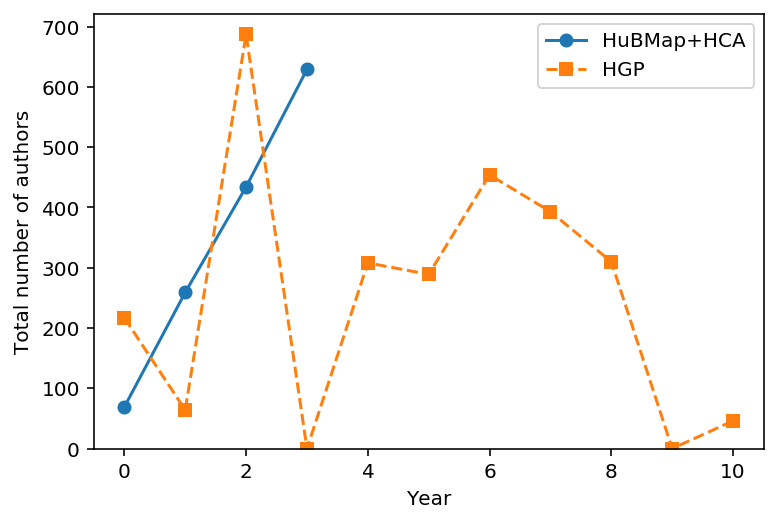

In [100]:

minYear = 1990
maxYear = 2020
markerStyles = [
  "o-",
  "s--",
  "^-.",
  "D:",
]
ax = plt.subplot(111)
for plotIndex,(projectName,(years,authorCount)) in enumerate(authorsByProject.items()):
    ax.plot(range(len(years)),authorCount,markerStyles[plotIndex%len(markerStyles)],label=projectName);

# ax.set_xlim(1997,2021)

ax.set_ylim(ymin=0)
ax.legend()
# ax.set_title("Citations over time")
ax.set_xlabel("Year")
ax.set_ylabel("Total number of authors")
plt.savefig("../../Figures/BioMedAuthorsTotal_v2.pdf")
plt.show()

In [71]:
with open("../../Data/BioMed_AffiliationsData.json","wt") as fd:
    ujson.dump(affiliationsByProject,fd)
with open("../../Data/BioMed_TotalAffiliationsData.json","wt") as fd:
    ujson.dump(totalAffiliationsByProject,fd)

In [74]:
with open("../../Data/BioMed_AuthorsData.json","wt") as fd:
    ujson.dump(authorsByProject,fd)
with open("../../Data/BioMed_TotalAuthorsData.json","wt") as fd:
    ujson.dump(totalAuthorsByProject,fd)

In [104]:
from collections import Counter
publicationsByProject = {}
for projectName,dfProject in dfBioMed.items():
    years,publicationCount = list(zip(*sorted(list(Counter(dfProject['Year']).items()),key=lambda x:x[0])))
    minYear = dfProject["Year"].min()
    maxYear = dfProject["Year"].max()
    
    publicationsByProject[projectName] = [years,publicationCount]

In [103]:
with open("../../Data/BioMed_PublicationsData.json","wt") as fd:
    ujson.dump(publicationsByProject,fd)

In [105]:
# Loading MAG Data
journalIndex2MAGID = np.loadtxt(PJ(dataPath,"MAGJournalIndex2ID.txt.gz"),dtype=int)
journalMAGID2Index = dictFromList(journalIndex2MAGID)
journalMAGID2Index = {ID:index for index,ID in enumerate(journalIndex2MAGID)};
with gzip.open(PJ(dataPath,"MAGJournalNames.txt.gz"),"rt") as fd:
    journalMAGNames = [line.strip() for line in fd]
    
with gzip.open(PJ(dataPath,"MAGJournalLongNames.txt.gz"),"rt") as fd:
    journalMAGLongNames = [line.strip() for line in fd]
    
with gzip.open(PJ(dataPath,"MAGJournalRankings.txt.gz"),"rt") as fd:
    journalMAGRankings = [int(line.strip()) for line in fd]
    
with gzip.open(PJ(dataPath,"MAGJournalPublishers.txt.gz"),"rt") as fd:
    journalMAGPublishers = [line.strip() for line in fd]
    
with gzip.open(PJ(dataPath,"MAGJournalPaperCounts.txt.gz"),"rt") as fd:
    journalMAGPaperCounts = [int(line.strip()) for line in fd]
    
with gzip.open(PJ(dataPath,"MAGJournalISSN.txt.gz"),"rt") as fd:
    journalMAGISSN = [line.strip() for line in fd]

In [127]:
for projectName,df in dfBioMed.items():
    df["Journal Name"] = [journalMAGNames[journalMAGID2Index[int(ID)]] if ID else "" for ID in df["JournalId"]]
    df["Journal Long Name"] = [journalMAGLongNames[journalMAGID2Index[int(ID)]] if ID else "" for ID in df["JournalId"]]
    df.to_csv("../../Data/Papers_%s_v2.tsv"%projectName,sep='\t')